In [1]:
import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from torchvision.models import mobilenet_v2
from PIL import Image

import numpy as np
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
class MURABinaryDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.samples = []
        self.transform = transform

        for root, _, files in os.walk(root_dir):
            for file in files:
                if file.endswith(".png"):
                    full_path = os.path.join(root, file)
                    label = 1 if "positive" in root.lower() else 0
                    self.samples.append((full_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        path, label = self.samples[idx]
        image = Image.open(path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, label

In [3]:
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

train_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/train", transform=transform)
valid_dataset = MURABinaryDataset("/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/data_sample/valid", transform=transform)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=16)

print(f"Train imgs: {len(train_dataset)} | Valid imgs: {len(valid_dataset)}")

Train imgs: 12 | Valid imgs: 11


In [4]:
DEVICE = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")

EPOCHS = 10
LEARNING_RATE = 1e-4
WEIGHT_DECAY = 1e-4
PATIENCE = 3

In [5]:
mobilenet = mobilenet_v2(weights="DEFAULT")
mobilenet.classifier[1] = nn.Linear(mobilenet.classifier[1].in_features, 2)
mobilenet = mobilenet.to(DEVICE)

In [6]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(mobilenet.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, mode='min', factor=0.5, patience=1, verbose=True)

best_val_loss = float('inf')
epochs_no_improve = 0
train_losses, val_losses = [], []

for epoch in range(EPOCHS):
    mobilenet.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        optimizer.zero_grad()
        outputs = mobilenet(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    avg_train_loss = running_loss / len(train_loader)
    train_losses.append(avg_train_loss)

    # Validación
    mobilenet.eval()
    val_loss = 0.0
    y_true, y_pred = [], []
    with torch.no_grad():
        for inputs, labels in valid_loader:
            inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
            outputs = mobilenet(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            y_true.extend(labels.cpu().numpy())
            y_pred.extend(preds.cpu().numpy())

    avg_val_loss = val_loss / len(valid_loader)
    val_losses.append(avg_val_loss)
    scheduler.step(avg_val_loss)

    acc = accuracy_score(y_true, y_pred)
    f1 = f1_score(y_true, y_pred)
    print(f"Epoch {epoch+1} | Train Loss: {avg_train_loss:.4f} | Val Loss: {avg_val_loss:.4f} | Acc: {acc:.4f} | F1: {f1:.4f}")

    if avg_val_loss < best_val_loss:
        best_val_loss = avg_val_loss
        epochs_no_improve = 0
        torch.save(mobilenet.state_dict(), "/Users/alvarosanchez/ONLINE_DS_THEBRIDGE_ALVAROSMMS-1/ML_Clasificacion_Radiografias_Muscoesqueleticas/src/models/mobilenetv2_binario.pt")
        print("Mejor modelo guardado.")
    else:
        epochs_no_improve += 1
        if epochs_no_improve >= PATIENCE:
            print("Early stopping activado.")
            break


/opt/homebrew/lib/python3.11/site-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1 | Train Loss: 0.7405 | Val Loss: 0.7243 | Acc: 0.3636 | F1: 0.0000
Mejor modelo guardado.
Epoch 2 | Train Loss: 0.5875 | Val Loss: 0.7210 | Acc: 0.4545 | F1: 0.2500
Mejor modelo guardado.
Epoch 3 | Train Loss: 0.4705 | Val Loss: 0.7186 | Acc: 0.3636 | F1: 0.2222
Mejor modelo guardado.
Epoch 4 | Train Loss: 0.3544 | Val Loss: 0.7139 | Acc: 0.3636 | F1: 0.2222
Mejor modelo guardado.
Epoch 5 | Train Loss: 0.3074 | Val Loss: 0.7112 | Acc: 0.3636 | F1: 0.2222
Mejor modelo guardado.
Epoch 6 | Train Loss: 0.2562 | Val Loss: 0.7114 | Acc: 0.2727 | F1: 0.0000
Epoch 7 | Train Loss: 0.2022 | Val Loss: 0.7105 | Acc: 0.2727 | F1: 0.0000
Mejor modelo guardado.
Epoch 8 | Train Loss: 0.1718 | Val Loss: 0.7112 | Acc: 0.2727 | F1: 0.0000
Epoch 9 | Train Loss: 0.1521 | Val Loss: 0.7095 | Acc: 0.2727 | F1: 0.0000
Mejor modelo guardado.
Epoch 10 | Train Loss: 0.1260 | Val Loss: 0.7071 | Acc: 0.3636 | F1: 0.0000
Mejor modelo guardado.



 Reporte de Clasificación:
              precision    recall  f1-score   support

    negative       0.40      0.80      0.53         5
    positive       0.00      0.00      0.00         6

    accuracy                           0.36        11
   macro avg       0.20      0.40      0.27        11
weighted avg       0.18      0.36      0.24        11



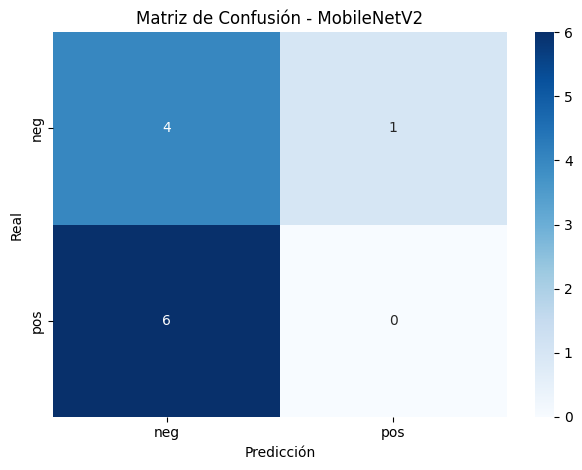

In [7]:
print("\n Reporte de Clasificación:")
print(classification_report(y_true, y_pred, target_names=["negative", "positive"]))

cm = confusion_matrix(y_true, y_pred)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=["neg", "pos"], yticklabels=["neg", "pos"])
plt.title("Matriz de Confusión - MobileNetV2")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.tight_layout()
plt.show()